# Dataset.py

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Utility.py

In [4]:
import torch
import torchvision
# from dataset import CarvanaDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    # val_ds = CarvanaDataset(
    #     image_dir=val_dir,
    #     mask_dir=val_maskdir,
    #     transform=val_transform,
    # )

    # val_loader = DataLoader(
    #     val_ds,
    #     batch_size=batch_size,
    #     num_workers=num_workers,
    #     pin_memory=pin_memory,
    #     shuffle=False,
    # )

    # return train_loader, val_loader
    return train_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

        if idx == 3:
            break

    model.train()

In [7]:
import torch
import torchvision
# from dataset import SegmentedDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    # val_ds = SegmentedDataset(
    #     image_dir=val_dir,
    #     mask_dir=val_maskdir,
    #     transform=val_transform,
    # )

    # val_loader = DataLoader(
    #     val_ds,
    #     batch_size=batch_size,
    #     num_workers=num_workers,
    #     pin_memory=pin_memory,
    #     shuffle=False,
    # )

    val_loader = None   

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    
    if loader:
        model.eval()
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device).unsqueeze(1)
                preds = torch.sigmoid(model(x)) # Sigmoid to get range between 0 and 1
                preds = (preds > 0.5).float()
                num_correct += (preds == y).sum()
                num_pixels += torch.numel(preds)
                dice_score += (2 * (preds * y).sum()) / (
                    (preds + y).sum() + 1e-8
                )

        print(
            f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
        )
        print(f"Dice score: {dice_score/len(loader)}")
        model.train()


def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

        if idx == 3:
            break

    model.train()

# Model.py

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

# Train.py

In [19]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim


# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 3
NUM_WORKERS = 0
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "C:\\Users\\pc\\Downloads\\Car\\train\\train"
TRAIN_MASK_DIR = "C:\\Users\\pc\\Downloads\\Car\\train_masks\\train_masks"
VAL_IMG_DIR = None
VAL_MASK_DIR = None

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)


    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


In [ ]:

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Loading")

train_loader, val = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
)

print("Loaded")

# if LOAD_MODEL:
#     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


# check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    # checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer":optimizer.state_dict(),
    # }
    # save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(train_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        train_loader, model, folder="saved_images/", device=DEVICE
    )



In [20]:
# torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

# DiceLoss

In [23]:
def dice_loss(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)  # Apply sigmoid to predictions
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [24]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard



# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_WORKERS = 0
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "C:\\Users\\pc\\Downloads\\Car\\train\\train"
TRAIN_MASK_DIR = "C:\\Users\\pc\\Downloads\\Car\\train_masks\\train_masks"
VAL_IMG_DIR = None
VAL_MASK_DIR = None

# Initialize TensorBoard writer
writer = SummaryWriter("runs/car_segmentation")


def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)


    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        
        # Log images to TensorBoard
        if batch_idx == 0:
            writer.add_image("Input Image", data[0].cpu(), epoch)
            writer.add_image("Ground Truth", targets[0].cpu(), epoch)
            writer.add_image("Predicted Mask", torch.sigmoid(predictions[0]).cpu(), epoch)
            writer.add_scalar("Loss/train", loss.item(), epoch * len(loader) + batch_idx)



In [25]:

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
# loss_fn = nn.BCEWithLogitsLoss()
loss_fn = dice_loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Loading")

train_loader, val = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
)

print("Loaded")

# if LOAD_MODEL:
#     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


# check_accuracy(val_loader, model, device=DEVICE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    # checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer":optimizer.state_dict(),
    # }
    # save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(train_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        train_loader, model, folder="saved_images/", device=DEVICE
    )

writer.close()


C:\Users\pc\AppData\Local\Temp\ipykernel_41168\2991310734.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Loading
Loaded


  0%|          | 0/159 [00:00<?, ?it/s]C:\Users\pc\AppData\Local\Temp\ipykernel_41168\154427516.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 159/159 [02:36<00:00,  1.02it/s, loss=0.278]


Got 192857506/195379200 with acc 98.71
Dice score: 0.9699569344520569


100%|██████████| 159/159 [02:35<00:00,  1.02it/s, loss=0.204]


Got 193041787/195379200 with acc 98.80
Dice score: 0.9723381996154785


100%|██████████| 159/159 [02:36<00:00,  1.02it/s, loss=0.146]


Got 193747602/195379200 with acc 99.16
Dice score: 0.9804551005363464


100%|██████████| 159/159 [02:35<00:00,  1.02it/s, loss=0.127]


Got 193856568/195379200 with acc 99.22
Dice score: 0.9817091822624207


100%|██████████| 159/159 [02:35<00:00,  1.02it/s, loss=0.0922]


Got 193735930/195379200 with acc 99.16
Dice score: 0.9803848266601562


In [28]:
torch.save(model.state_dict(), f"unet_epoch_{epoch+1}.pth")

# Test

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
model.load_state_dict(torch.load("unet_epoch_3.pth"))

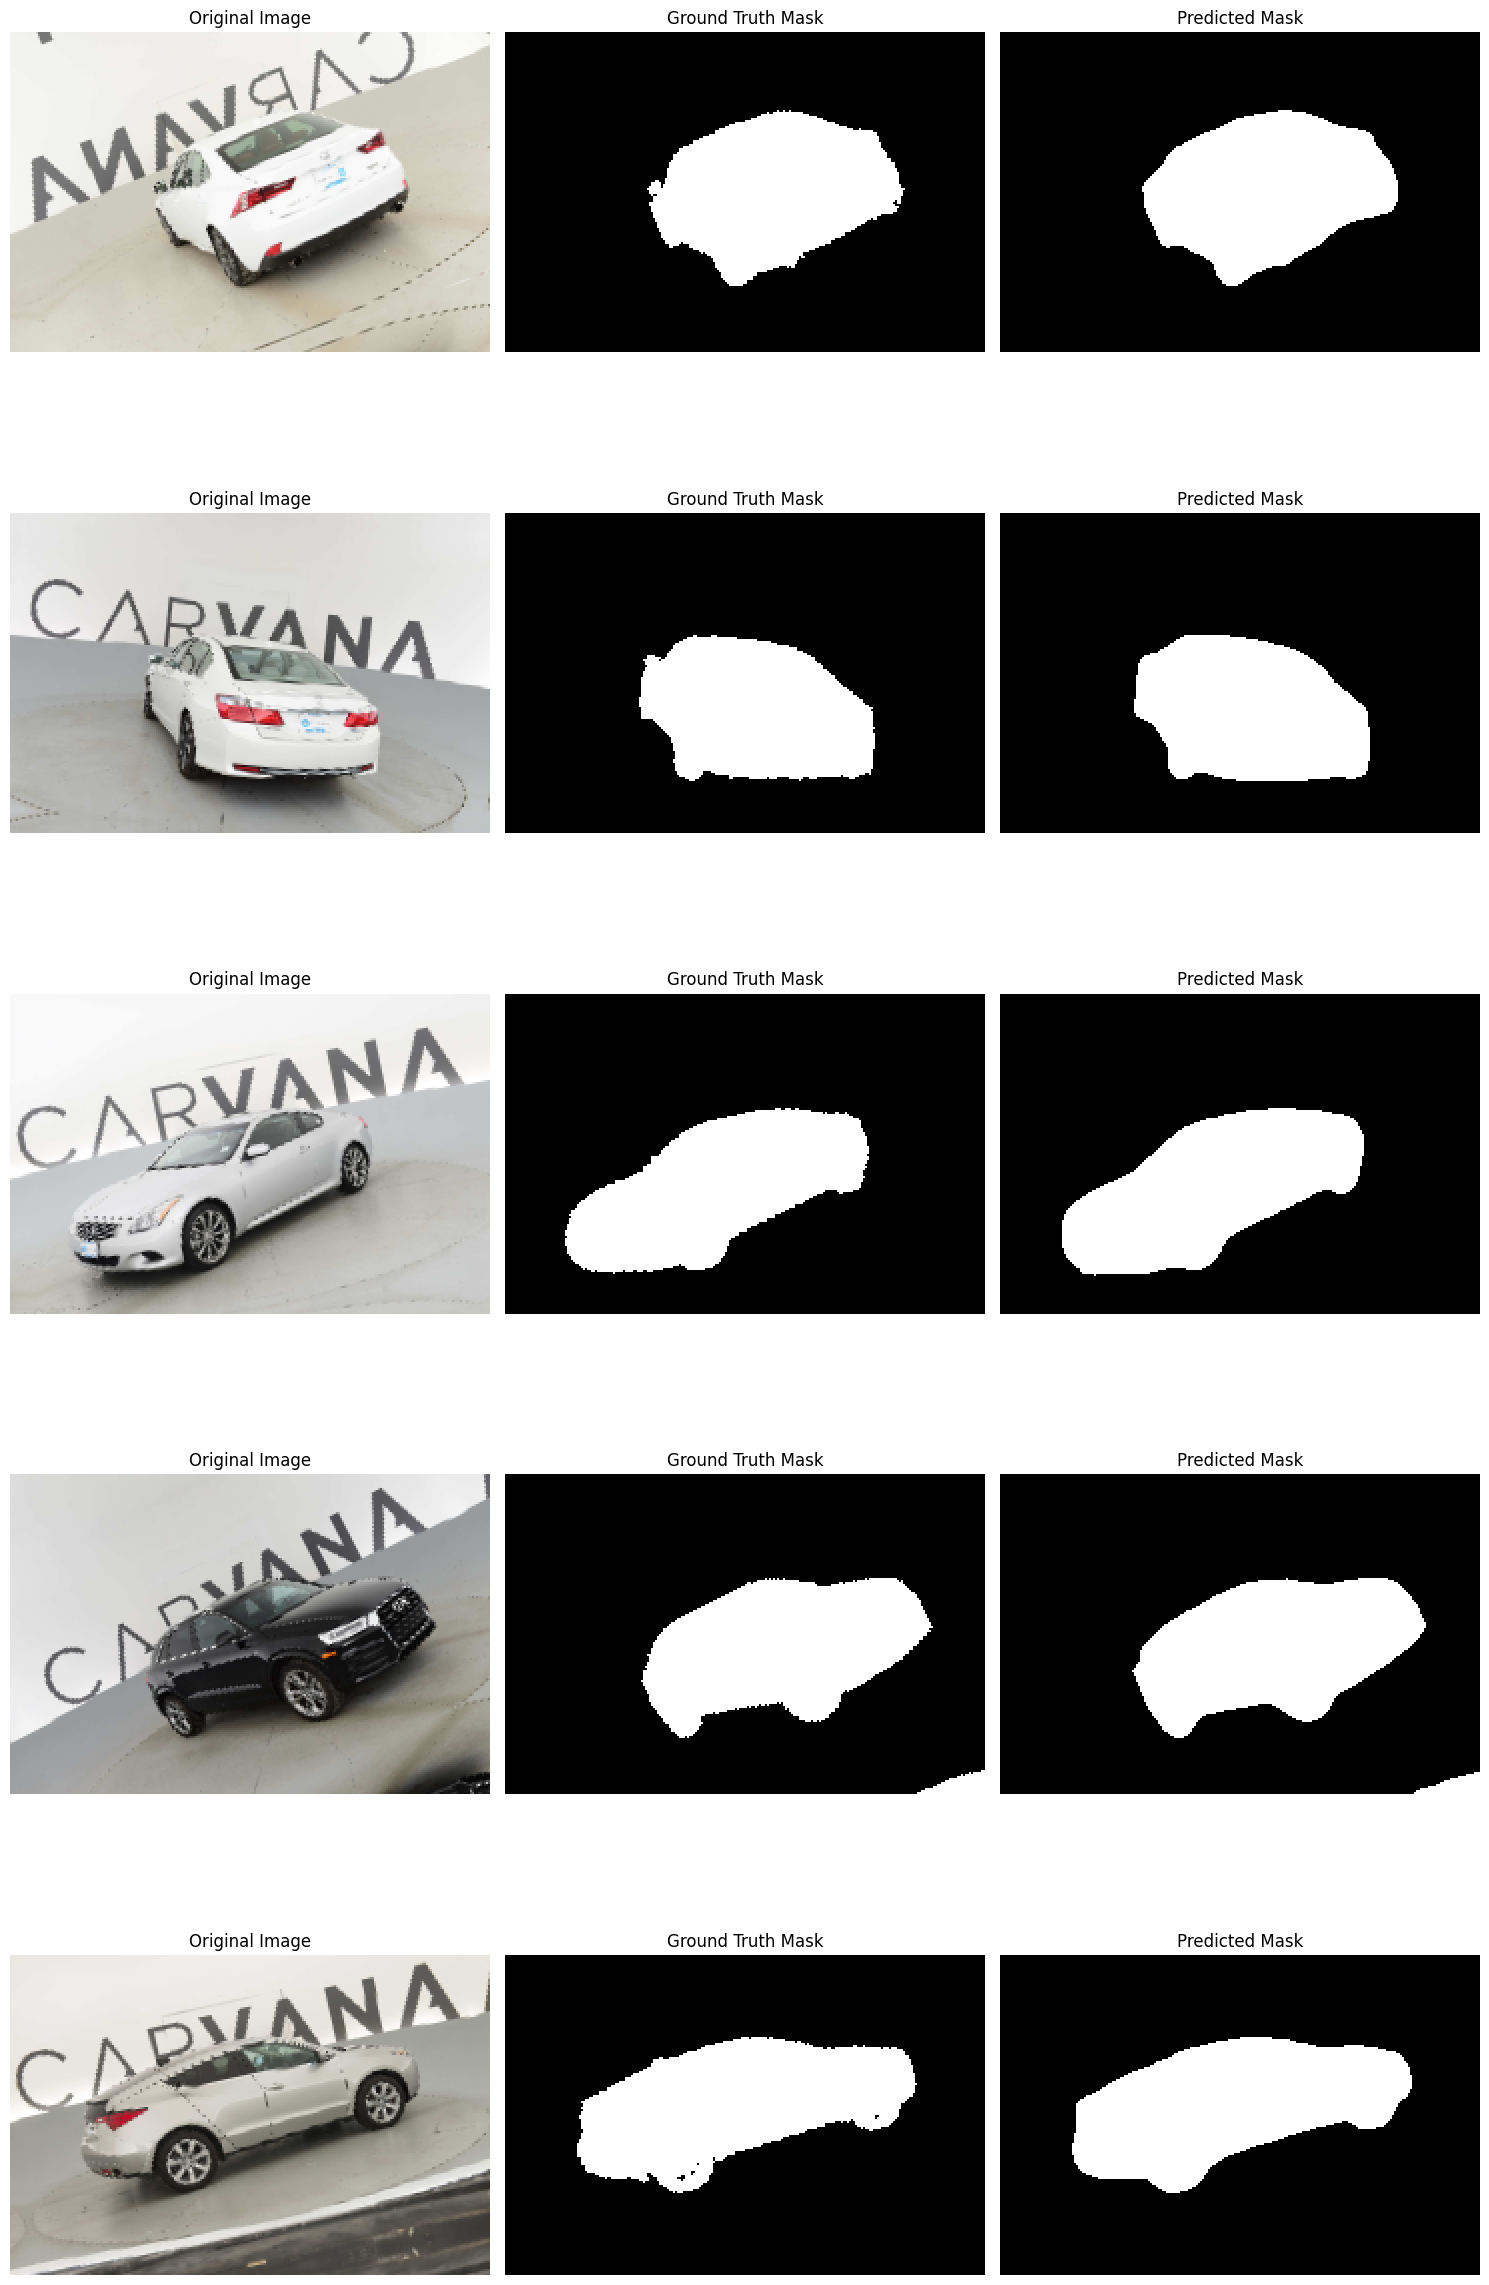

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid

def visualize_predictions(model, loader, device, num_images=5):
    model.eval()
    images, true_masks, pred_masks = [], [], []
    with torch.no_grad():
        for idx, (data, targets) in enumerate(loader):
            data = data.to(device=device)
            targets = targets.float().unsqueeze(1).to(device=device)
            
            predictions = torch.sigmoid(model(data))
            predictions = (predictions > 0.5).float()

            images.extend(data.cpu().numpy())
            true_masks.extend(targets.cpu().numpy())
            pred_masks.extend(predictions.cpu().numpy())
            
            if len(images) >= num_images:
                break

    # Plotting the images, their true masks, and the predicted masks
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')
        
        # Ground Truth Mask
        axes[i, 1].imshow(np.squeeze(true_masks[i]), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        # Predicted Mask
        axes[i, 2].imshow(np.squeeze(pred_masks[i]), cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_predictions(model, train_loader, device=DEVICE, num_images=5)